## The example shows covariance Intersection applied on two noisy observations of a still object (location=0, velocity=0), and compares the predicted results with a naive fusion method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from enum import Enum
from scipy.optimize import fminbound
from numpy.linalg import inv, det
from pykalman import KalmanFilter

In [2]:
# A model with constant velocity, state is [position, velocity]
class ConstantVelocity():
    def __init__(self, initial_state, delta_t=0.1, noise_variance=10):
        # state transition matrix F
        self.F = np.matrix([[1.0, delta_t],
                            [0, 1.0]])
        self.G = np.array([[(delta_t ** 2) / 2.0],
                           [delta_t]])
        self.Q = np.multiply(noise_variance, np.dot(self.G, self.G.T))
        self.noise_stddev = np.sqrt(noise_variance)
        self.current_state = initial_state
        self.states = []

    def step(self):
        """
        Updates the current state.
        """
        process_noise = np.random.normal(0, scale=self.noise_stddev)
        self.current_state = np.dot(self.F, self.current_state) + np.multiply(self.G, process_noise)
        self.states.append(self.current_state)

    def plot(self, axes):
        """
        Creates a pyplot figure of the model's state history.
        """
        states = list(map(lambda x: np.squeeze(np.asarray(x)), self.states))
        positions = [state[0] for state in states]
        velocities = [state[1] for state in states]
        axes.plot(positions, label="Position [m]")
        axes.plot(velocities, label="Velocity [m/s]")
        axes.legend()
        return axes

In [3]:
# A simulated sensor node. Each node runs its own, local Kalman filter to estimate the state.
class KalmanSensorNode():
    def __init__(self, node_id, state_dims, process, fusion_algorithm, transition_matrix, transition_covariance, measurement_covariance):
        self.node_id = node_id
        self.state_dims = state_dims
        self.measurement_covariance = measurement_covariance
        self.mean = np.zeros(shape=(state_dims,))
        self.cov = np.identity(state_dims)
        self.kf = KalmanFilter(transition_matrices=transition_matrix, transition_covariance=transition_covariance, observation_covariance=measurement_covariance)
        self.process = process
        self.fusion_algorithm = fusion_algorithm
        self.local_estimates = []
        self.fused_estimates = []

    def estimate(self):
        measurement_noise = np.random.multivariate_normal([0 for dim in range(self.state_dims)], self.measurement_covariance)
        noisy_measurement = np.squeeze(np.asarray(self.process.current_state)) + measurement_noise
        self.mean, self.cov = self.kf.filter_update(self.mean, self.cov, noisy_measurement)
        self.local_estimates.append((self.mean, self.cov))
        return self.mean, self.cov

    def fuse_in(self, mean, cov):
        self.mean, self.cov = self.fusion_algorithm.fuse(self.mean, self.cov, mean, cov)
        self.fused_estimates.append((self.mean, self.cov))
        return self.mean, self.cov



In [4]:
# naive fusion for comparison
class Naive():
    def __init__(self):
        self.algorithm_name = "Naive"
        self.algorithm_abbreviation = "Naive"

    def fuse(self, mean_a, cov_a, mean_b, cov_b):
        cov_a_inv = inv(cov_a)
        cov_b_inv = inv(cov_b)
        cov = inv(cov_a_inv + cov_b_inv)
        K = np.dot(cov, cov_a_inv)
        L = np.dot(cov, cov_b_inv)
        mean = np.dot(K, mean_a) + np.dot(L, mean_b)
        return mean, cov

In [5]:
# CI algorithm
class CovarianceIntersection():
    def __init__(self):
        # could maybe use det also
        self.performance_criterion = np.trace
        self.algorithm_name = "Covariance Intersection"
        self.algorithm_abbreviation = "CI"

    def fuse(self, mean_a, cov_a, mean_b, cov_b):
        omega = self.optimize_omega(cov_a, cov_b)
        cov = inv(np.multiply(omega, inv(cov_a)) + np.multiply(1 - omega, inv(cov_b)))
        mean = np.dot(cov, (np.dot(np.multiply(omega, inv(cov_a)), mean_a) + np.dot(np.multiply(1 - omega, inv(cov_b)), mean_b)))
        return mean, cov
    
    # methond to find the optimal omega
    def optimize_omega(self, cov_a, cov_b):
        def optimize_fn(omega):
            return self.performance_criterion(inv(np.multiply(omega, inv(cov_a)) + np.multiply(1 - omega, inv(cov_b))))
        return fminbound(optimize_fn, 0, 1)


A simulation: an still object at position 0, with speed=0.

In [6]:
class SimpleSensorNetworkSimulation():
    def __init__(self, fusion_algorithm):
        init_state = np.array([0, 0]).T.reshape(-1,1) # position=0, velocity=0
        self.process = ConstantVelocity(initial_state=init_state, delta_t=0.01)
        random_matrix_A = np.random.rand(2,2) * 0.3
        random_matrix_B = np.random.rand(2,2) * 0.3
        # measurement_covariance a and b
        measurement_cov_a = np.dot(random_matrix_A, random_matrix_A.T)
        measurement_cov_b = np.dot(random_matrix_B, random_matrix_B.T)
        # two nodes
        self.node_a = KalmanSensorNode(0, 2, self.process, fusion_algorithm, transition_matrix=self.process.F, transition_covariance=self.process.Q, measurement_covariance=measurement_cov_a)
        self.node_b = KalmanSensorNode(1, 2, self.process, fusion_algorithm, transition_matrix=self.process.F, transition_covariance=self.process.Q, measurement_covariance=measurement_cov_b)
    
    def run(self, num_timesteps):
        for t in range(num_timesteps):
            self.process.step()
            mean_a, cov_a = self.node_a.estimate()
            mean_b, cov_b = self.node_b.estimate()
            self.node_a.fuse_in(mean_b, cov_b)
            self.node_b.fuse_in(mean_a, cov_a)


In [7]:
# functions to plot the results and square error
def plot_results(fusion_algorithms, process_states, fused_estimates, node="A"):
    pos_real = [x[0] for x in process_states]
    vel_real = [x[1] for x in process_states]
    pos_fused = {}
    vel_fused = {}
    for alg in fusion_algorithms:
        pos_fused[alg.algorithm_abbreviation] = [x[0][0] for x in fused_estimates[alg.algorithm_abbreviation][node]]
        vel_fused[alg.algorithm_abbreviation] = [x[0][1] for x in fused_estimates[alg.algorithm_abbreviation][node]]

    plt.rcParams["figure.figsize"] = (6, 4)
    res_fig = plt.figure(2)
    pos_axes = res_fig.add_subplot(2, 1, 1)
    pos_axes.plot(pos_real, color="black", linestyle="dashed", label="Real")
    for alg in pos_fused.keys():
        pos_axes.plot(pos_fused[alg], label=alg)
    pos_axes.legend()
    pos_axes.set_title("Position (Node {})".format(node))
    pos_axes.set_xlabel("Timestep")

    vel_axes = res_fig.add_subplot(2, 1, 2)
    vel_axes.plot(vel_real, color="black", linestyle="dashed", label="Real")
    for alg in vel_fused.keys():
        vel_axes.plot(vel_fused[alg], label=alg)
    vel_axes.legend()
    vel_axes.set_title("Velocity (Node {})".format(node))
    vel_axes.set_xlabel("Timestep")
    res_fig.tight_layout()
    res_fig.show()

def plot_estimation_errors(fusion_algorithms, process_states, fused_estimates, node="A"):
    pos_real = [x[0] for x in process_states]
    vel_real = [x[1] for x in process_states]
    pos_fused = {}
    vel_fused = {}
    for alg in fusion_algorithms:
        pos_fused[alg.algorithm_abbreviation] = [x[0][0] for x in fused_estimates[alg.algorithm_abbreviation][node]]
        vel_fused[alg.algorithm_abbreviation] = [x[0][1] for x in fused_estimates[alg.algorithm_abbreviation][node]]
    pos_squared_errors = {}
    vel_squared_errors = {}
    for alg in fusion_algorithms:
        alg_abbr = alg.algorithm_abbreviation
        pos_squared_errors[alg.algorithm_abbreviation] = [(pos_fused[alg_abbr][idx] - pos_real[idx])**2 for idx in range(len(pos_real))]
        vel_squared_errors[alg.algorithm_abbreviation] = [(vel_fused[alg_abbr][idx] - vel_real[idx])**2 for idx in range(len(vel_real))]

    #plt.rcParams["figure.figsize"] = (8, 8)
    res_fig = plt.figure()
    pos_axes = res_fig.add_subplot(2, 1, 1)
    for alg in pos_squared_errors.keys():
        pos_axes.plot(pos_squared_errors[alg], label=alg)
    pos_axes.legend()
    pos_axes.set_title("Squared Error (Position) (Node {})".format(node))
    pos_axes.set_xlabel("Timestep")

    vel_axes = res_fig.add_subplot(2, 1, 2)
    for alg in vel_squared_errors.keys():
        vel_axes.plot(vel_squared_errors[alg], label=alg)
    vel_axes.legend()
    vel_axes.set_title("Squared Error (Velocity) (Node {})".format(node))
    vel_axes.set_xlabel("Timestep")
    res_fig.tight_layout()
    res_fig.show()

def plot_process(process):
    plt.rcParams["figure.figsize"] = (4, 3)
    proc_fig = plt.figure()
    proc_axes = proc_fig.add_subplot(111)
    proc_axes.set_xlabel("Timestep")
    process.plot(proc_axes)
    proc_fig.show()



Seed: 412
Timesteps: 50
Running simulation 0 (Naive)
<function trace at 0x7f16e006ff80>
Running simulation 1 (CI)


/home/mt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/mt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/mt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


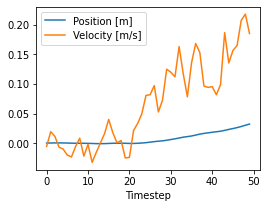

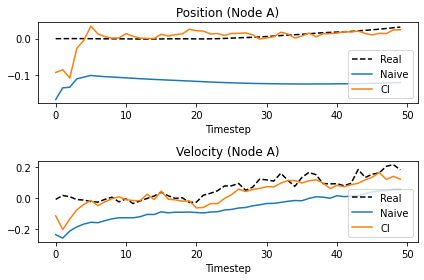

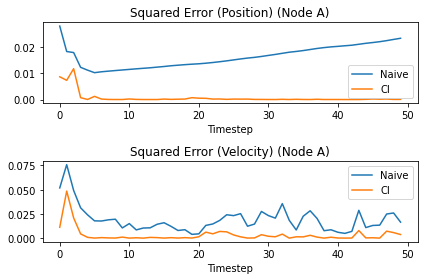

In [8]:
seed = random.randint(0, 1000)
print("Seed: {}".format(seed))
timesteps = 50
print("Timesteps: {}".format(timesteps))

fusion_algorithms = [Naive(), CovarianceIntersection()]#, EllipsoidalIntersection(), InverseCovarianceIntersection()]

process_states = []
local_estimates = {}
fused_estimates = {}

for i, fusion_algorithm in enumerate(fusion_algorithms):
    if i == 1:
        print(fusion_algorithm.performance_criterion)
    np.random.seed(seed)
    sim = SimpleSensorNetworkSimulation(fusion_algorithm)
    print("Running simulation {} ({})".format(i, fusion_algorithm.algorithm_abbreviation))
    sim.run(timesteps)
    if i == 0:
        process_states = list(map(lambda x: np.squeeze(np.asarray(x)), sim.process.states))
        plot_process(sim.process)
        # Save local estimates
        local_estimates["A"] = sim.node_a.local_estimates
        local_estimates["B"] = sim.node_b.local_estimates
    # Save fused estimates
    fused_estimates[fusion_algorithm.algorithm_abbreviation] = {
        "A": sim.node_a.fused_estimates,
        "B": sim.node_b.fused_estimates
    }
plot_results(fusion_algorithms, process_states, fused_estimates)
plot_estimation_errors(fusion_algorithms, process_states, fused_estimates)
  

The position and velocity predicted by CI has better accuracy than the naive fusion. The squared error of position and velocity of CI is also smaller than naive fusion.